# 👨‍⚕️ Projet Stroke Alert 👩‍⚕️

## 1. Préparation du jeu de données

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
print(f"Le dataFrame comporte {df.shape[0]} lignes, pour {df.shape[1]} colonnes. ")

Le dataFrame comporte 5110 lignes, pour 12 colonnes. 


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [14]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### ► Valeurs manquantes

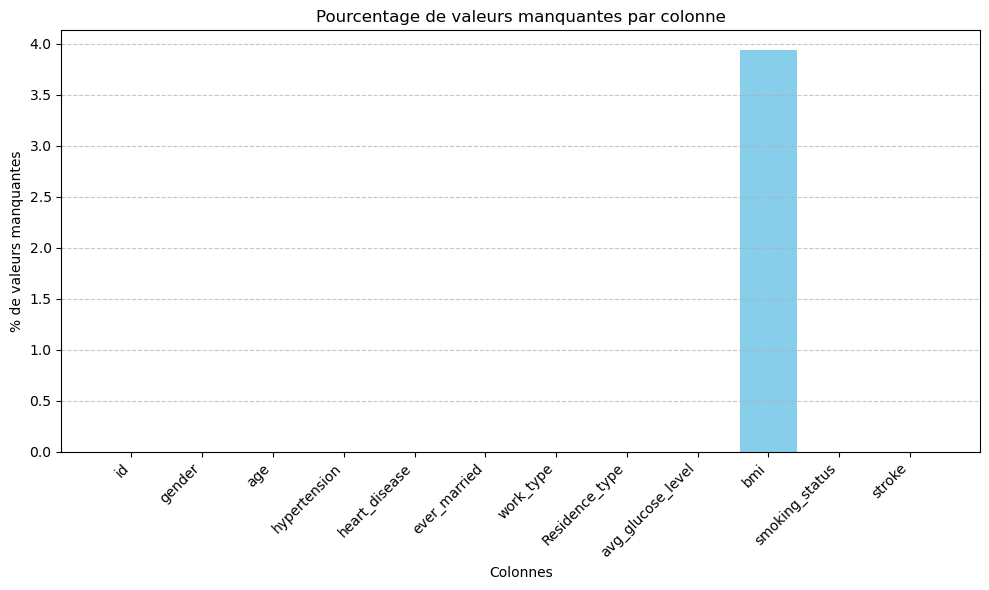

In [34]:
missing_percentages = [(1 - df[column].dropna().shape[0] / df[column].shape[0]) * 100 for column in df.columns]

plt.figure(figsize=(10, 6))
plt.bar(df.columns, missing_percentages, color='skyblue')
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ► Outliers

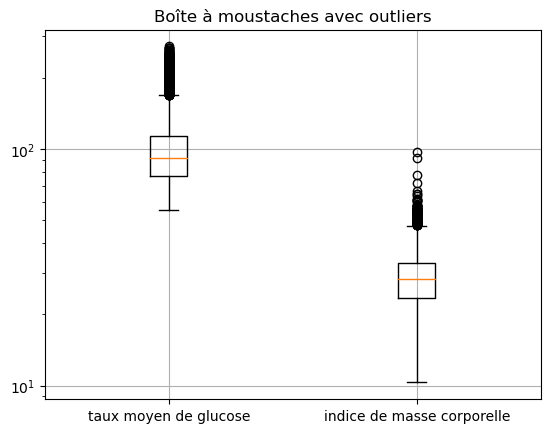

In [47]:
taux_moyen_glucose = df['avg_glucose_level']
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot([taux_moyen_glucose,indice_masse_corporelle], showfliers=True)
plt.xticks([1,2],['taux moyen de glucose','indice de masse corporelle'])
plt.yscale('log')
plt.title("Boîte à moustaches avec outliers")
plt.grid(True)
plt.show()

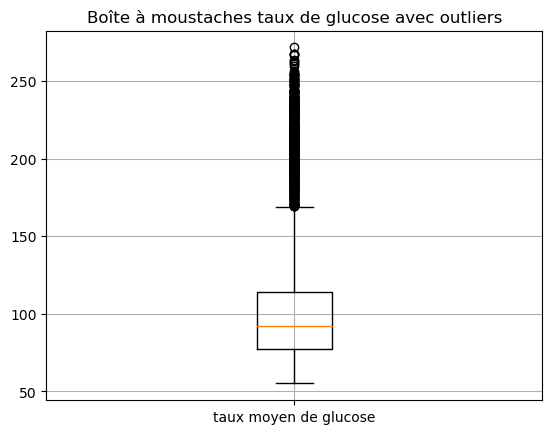

In [49]:
taux_moyen_glucose = df['avg_glucose_level']
plt.boxplot(taux_moyen_glucose, showfliers=True)
plt.xticks([1],['taux moyen de glucose'])
plt.title("Boîte à moustaches taux de glucose avec outliers")
plt.grid(True)
plt.show()

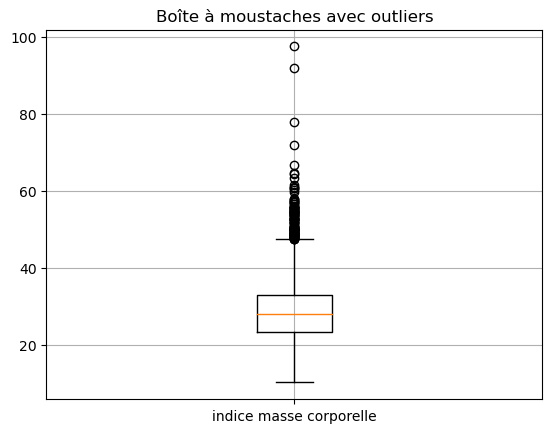

In [36]:
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot(indice_masse_corporelle, showfliers=True)
plt.xticks([1],['indice masse corporelle'])
plt.title("Boîte à moustaches IMC avec outliers")
plt.grid(True)
plt.show()

Ici, les outliers ne sont pas des valeurs abérantes. On les garde donc dans notre jeu de données.

In [71]:
df_patient_avc = df.loc[df['stroke'] == 1,:]
df_patient_no_avc = df.loc[df['stroke'] == 0,:]
print(f"Dans notre échantillon, il y a {df_patient_avc.shape[0]} patients ayant contracté un AVC.")

Dans notre échantillon, il y a 249 patients ayant contracté un AVC.


## 2. Analyse univariée 

### ► Genre 

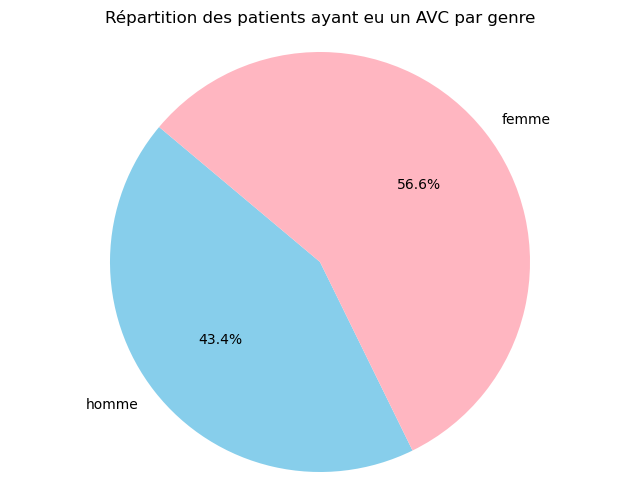

In [81]:
homme = (df_patient_avc['gender'] == 'Male').sum()
femme = (df_patient_avc['gender'] == 'Female').sum()

nombre_patients = [homme, femme]
labels = ['homme', 'femme']
colors = ['skyblue', 'lightpink']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients ayant eu un AVC par genre')
plt.axis('equal') 
plt.show()

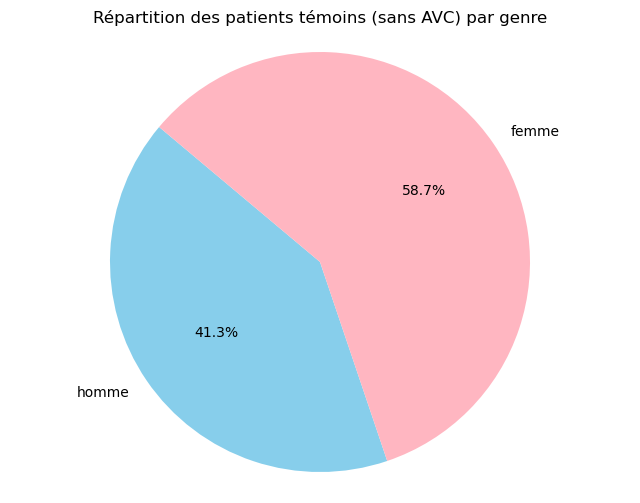

In [75]:
homme = (df_patient_no_avc['gender'] == 'Male').sum()
femme = (df_patient_no_avc['gender'] == 'Female').sum()

nombre_patients = [homme, femme]
labels = ['homme', 'femme']
colors = ['skyblue', 'lightpink']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients témoins (sans AVC) par genre')
plt.axis('equal') 
plt.show()

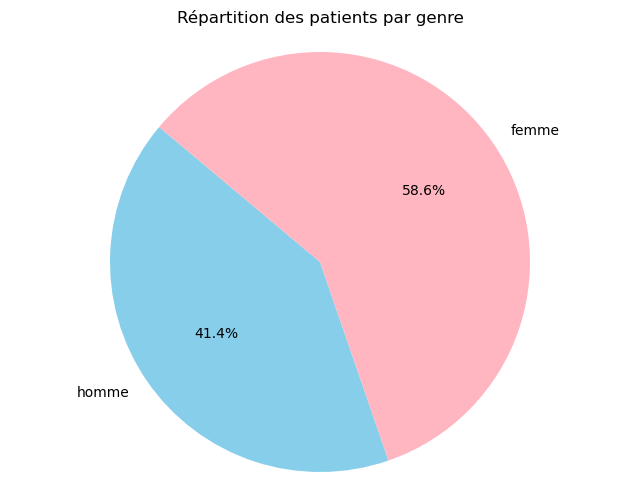

In [85]:
homme = (df['gender'] == 'Male').sum()
femme = (df['gender'] == 'Female').sum()

nombre_patients = [homme, femme]
labels = ['homme', 'femme']
colors = ['skyblue', 'lightpink']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients par genre')
plt.axis('equal') 
plt.show()

Étant donné la part inégale d'homme et femme dans cet échantillon, on ne pourra pas faire de conclusion sur cette variable.

### ► Résidence

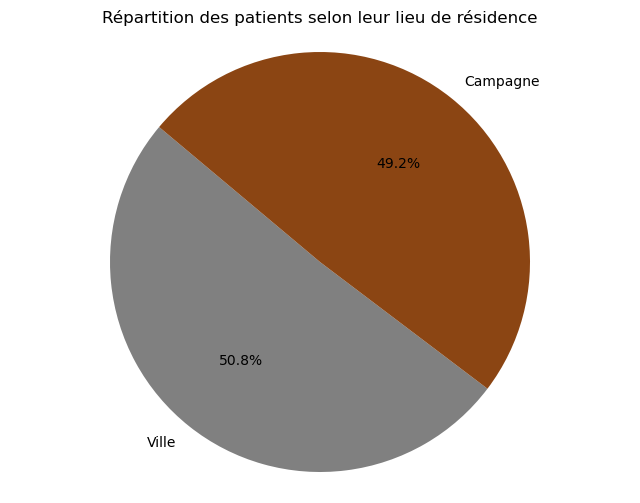

In [86]:
urbains = (df['Residence_type'] == 'Urban').sum()
ruraux = (df['Residence_type'] == 'Rural').sum()

nombre_patients = [urbains, ruraux]
labels = ['Ville', 'Campagne']
colors = ['grey', '#8B4513']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients selon leur lieu de résidence')
plt.axis('equal') 
plt.show()

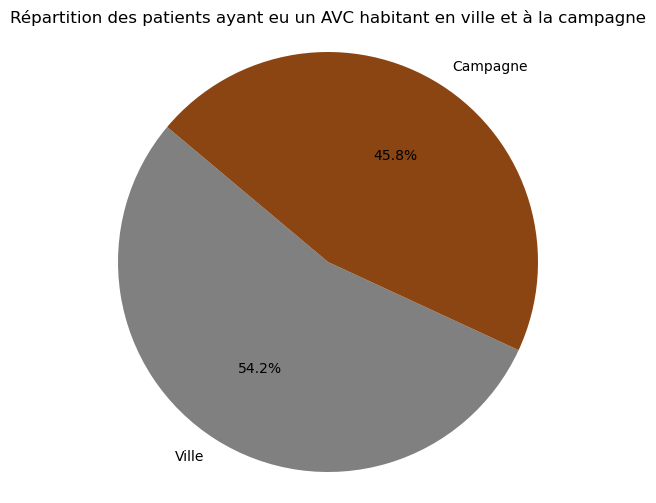

In [80]:
urbains = (df_patient_avc['Residence_type'] == 'Urban').sum()
ruraux = (df_patient_avc['Residence_type'] == 'Rural').sum()

nombre_patients = [urbains, ruraux]
labels = ['Ville', 'Campagne']
colors = ['grey', '#8B4513']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients ayant eu un AVC habitant en ville et à la campagne')
plt.axis('equal') 
plt.show()

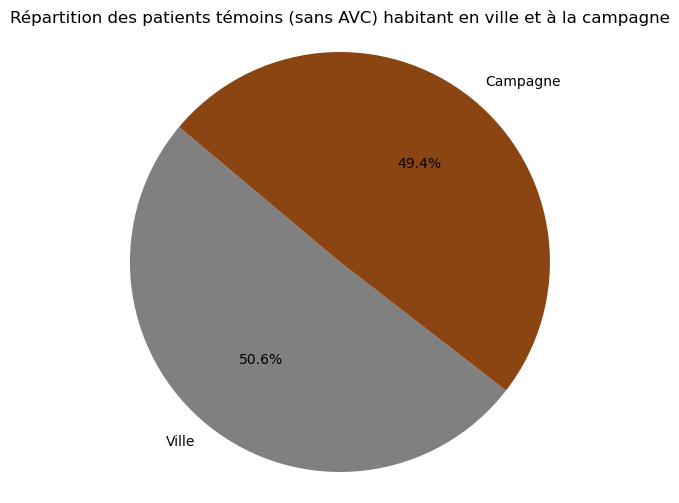

In [82]:
urbains = (df_patient_no_avc['Residence_type'] == 'Urban').sum()
ruraux = (df_patient_no_avc['Residence_type'] == 'Rural').sum()

nombre_patients = [urbains, ruraux]
labels = ['Ville', 'Campagne']
colors = ['grey', '#8B4513']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients témoins (sans AVC) habitant en ville et à la campagne')
plt.axis('equal') 
plt.show()

Peut-être qu'habiter en ville augmenterait légèrement les chances d'AVC.

### ► Âge

In [116]:
ages_tries = sorted(df['age'])
print(f"L'âge adaptée pour diviser le DataFrame en deux parts égale est {int(ages_tries[len(ages_tries)//2])} ans")

L'âge utile pour diviser le DataFrame en deux parts égale est 45 ans


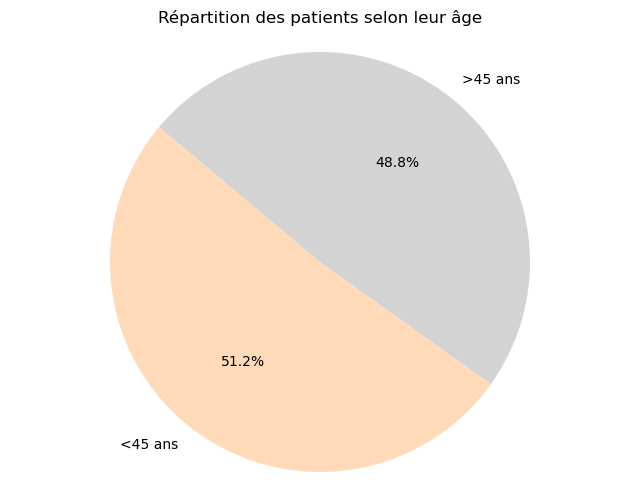

In [93]:
jeunes = (df['age'] <= 45).sum()
vieux = (df['age'] > 45).sum()

nombre_patients = [jeunes, vieux]
labels = ['<45 ans', '>45 ans']
colors = ['#FFDAB9', 'lightgrey']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients selon leur âge')
plt.axis('equal') 
plt.show()

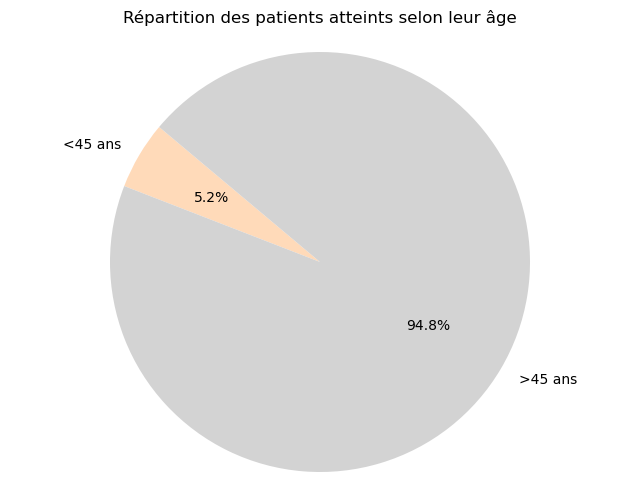

In [118]:
jeunes = (df_patient_avc['age'] <= 45).sum()
vieux = (df_patient_avc['age'] > 45).sum()

nombre_patients = [jeunes, vieux]
labels = ['<45 ans', '>45 ans']
colors = ['#FFDAB9', 'lightgrey']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients atteints selon leur âge')
plt.axis('equal') 
plt.show()

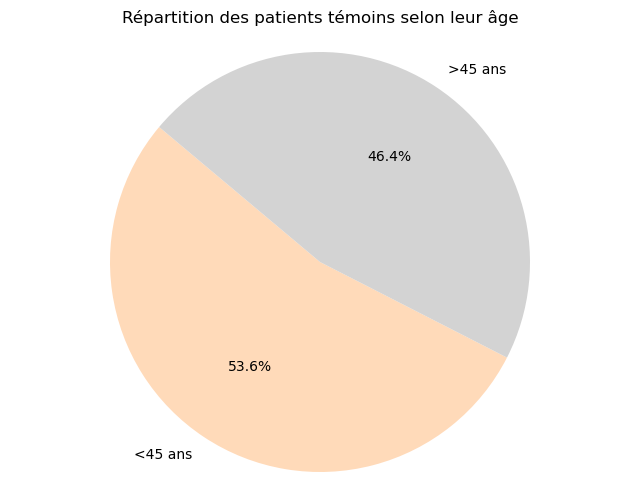

In [119]:
jeunes = (df_patient_no_avc['age'] <= 45).sum()
vieux = (df_patient_no_avc['age'] > 45).sum()

nombre_patients = [jeunes, vieux]
labels = ['<45 ans', '>45 ans']
colors = ['#FFDAB9', 'lightgrey']

plt.figure(figsize=(8, 6))
plt.pie(nombre_patients, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des patients témoins selon leur âge')
plt.axis('equal') 
plt.show()

L'âge a une forte incidence sur les chances d'avoir un AVC.

### ► Hypertension

In [126]:
tension_no_avc = (df_patient_no_avc['hypertension'] == 1).sum()
tension_avc = (df_patient_avc['hypertension'] == 1).sum()
print(f"Les patients faisant de l'hypertension représentent {round(100*(tension_no_avc/df_patient_no_avc.shape[0]))}% chez les témoins et {round(100*(tension_avc/df_patient_no_avc.shape[0]))}% chez les atteints.")

Les patients faisant de l'hypertension représentent 9% chez les témoins et 1% chez les atteints.


À priori, l'hypertension est une variable à écarter.